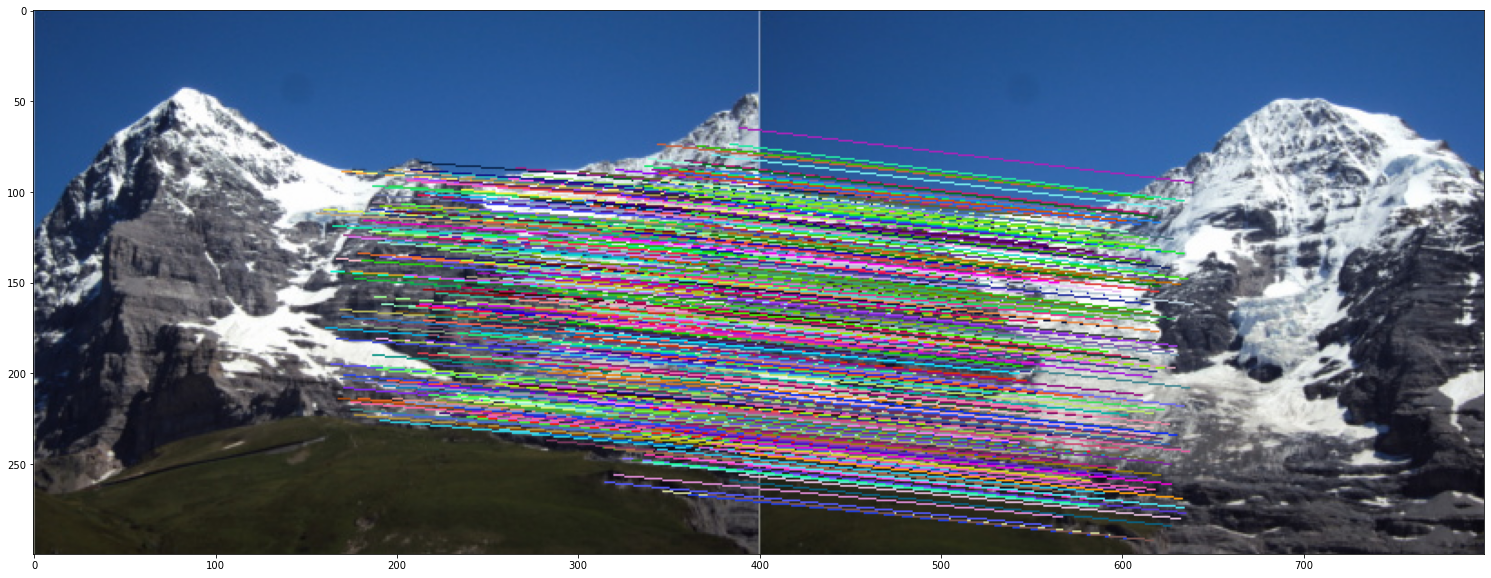

In [1]:
import numpy 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

# step 1. Interest points detection and feature description
## Read images
img1 = cv2.imread('data/hill1.jpg')
img2 = cv2.imread('data/hill2.jpg') # 2 images we want to stitch
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB) # convert channels BGR to RGB

## Find keypoints and compute desctriptors in 2 images
sift_detector = cv2.xfeatures2d.SIFT_create()
(kp1, desc1) = sift_detector.detectAndCompute(img1,None) # kp is cv2.KeyPoint object
(kp2, desc2) = sift_detector.detectAndCompute(img2,None) # desc is numpy ndarray

# step 2. Feature matching
## the Match provided by openCV
flann = cv2.FlannBasedMatcher()
matches = flann.knnMatch(desc1,desc2,k=2)
good_matchs = []
for (M1,M2) in matches:
    if (M1.distance / M2.distance) < 0.5: # ratio distance
        good_matchs.append([M1.queryIdx, M1.trainIdx])

## Visualize the matching result
### combine 2 images into 1
(h1, w1) = img1.shape[:2]
(h2, w2) = img2.shape[:2]
matching_result = np.zeros((max(h1, h2), w1 + w2, 3), dtype="uint8")
matching_result[0:h1, 0:w1] = img1
matching_result[0:h1, w1:] = img2
### draw the matching lines
for (i, j) in good_matchs:
    c = np.random.randint(0, high=255, size=(3,))
    color = tuple([int(x) for x in c])
    pt1 = (int(kp1[i].pt[0]), int(kp1[i].pt[1]))
    pt2 = (int(kp2[j].pt[0] + w1), int(kp2[j].pt[1]))
    cv2.line(matching_result, pt1, pt2, color, 1)

plt.figure(figsize=(26,13))
plt.imshow(matching_result)
plt.show()


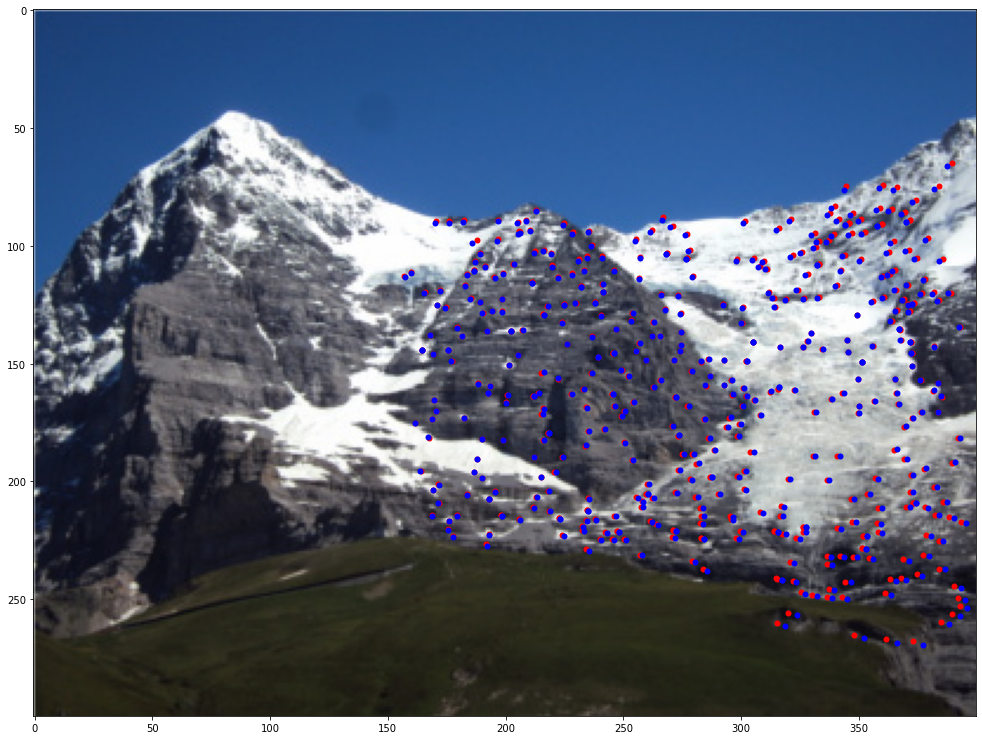

In [2]:
#config
RANSAC_sample_num = 4
RANSAC_iter = 10000
threshold_distance = 5
threshold_inliners = 1

image1_kp = np.float32([kp1[i].pt for (i, _) in good_matchs])   
image2_kp = np.float32([kp2[i].pt for (_, i) in good_matchs]) 
image1_kp = np.insert(image1_kp, 2, 1, axis=1)
image2_kp = np.insert(image2_kp, 2, 1, axis=1)

#find best Homography matrix
for i in range(RANSAC_iter):
    ##get temp H via matches selected randomly
    rand_set = random.sample(good_matchs, RANSAC_sample_num)
    img1_kps = np.float32([kp1[i].pt for (i, _) in rand_set])
    img2_kps = np.float32([kp2[i].pt for (_, i) in rand_set])
    _H, _ = cv2.findHomography(img2_kps, img1_kps)
    ##calculate deviation of corresponding keypoints
    _projected_pts = np.dot(_H, image2_kp.T)
    error = np.sqrt(np.sum(np.square(image1_kp.T - (_projected_pts/_projected_pts[-1])), axis=0))
    
    ##count inliners
    inliners = np.count_nonzero(error < threshold_distance)
    
    ##Update 
    if inliners > threshold_inliners:
        ###preserve best Homography matrix
        H = _H
        projected_pts = (_projected_pts/_projected_pts[-1]).T
        threshold_inliners = inliners

#testing if H is good or not
img1_x, img1_y = image1_kp[:,0], image1_kp[:,1]
img2_x, img2_y = projected_pts[:,0], projected_pts[:,1]
plt.figure(figsize=(26,13)), plt.imshow(img1)
plt.scatter(img1_x,img1_y,linewidths=0.001,color = 'red')
plt.scatter(img2_x,img2_y,linewidths=0.001,color = 'blue')
plt.show()


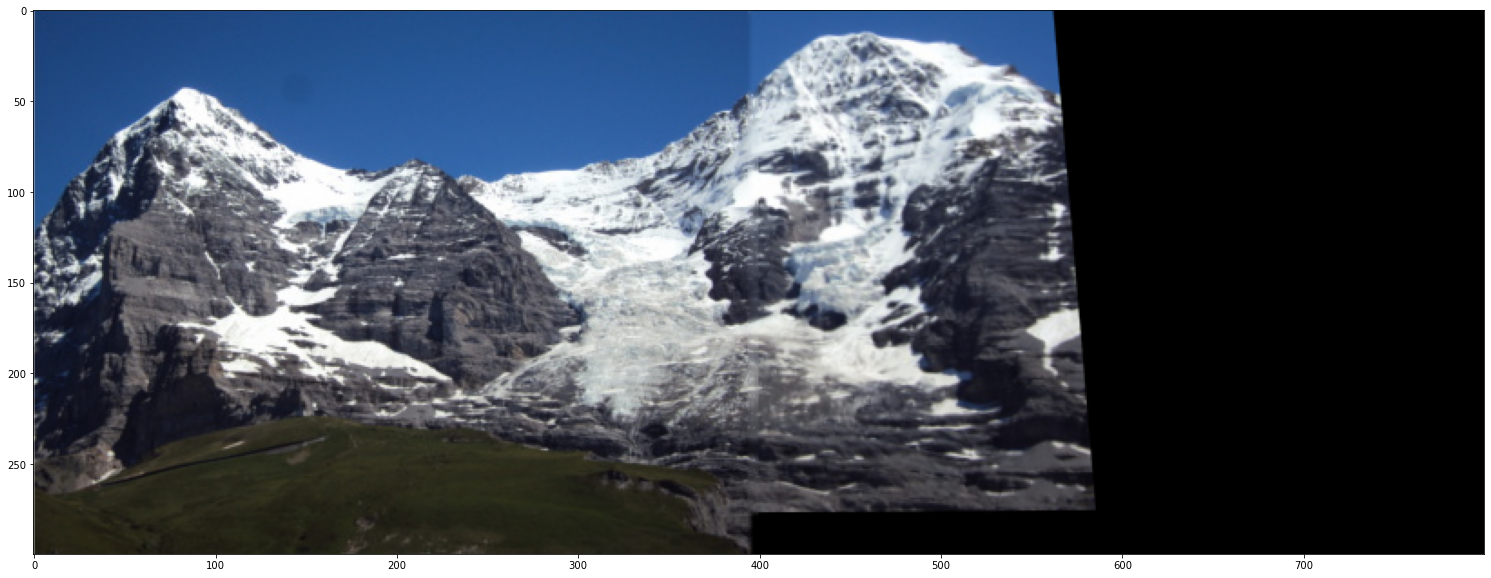

In [10]:
def get_gaussian_pyramid(img, pyramid_num):
    G = img.copy()
    gp = [G]
    for _ in range(pyramid_num):
        G = cv2.pyrDown(G)
        gp.append(G)
    return gp

def get_laplacian_pyramid(gp, pyramid_num):
    lp = [gp[pyramid_num-1]]
    for i in range(pyramid_num-1, 0, -1):
        GE = cv2.pyrUp(gp[i], dstsize=gp[i-1].shape[:2][::-1])
        L = cv2.subtract(gp[i-1], GE)
        lp.append(L)
    return lp

def pyramid_blending(img1, img2, pyramid_num):

    # Get Gaussian pyramid
    gp1 = get_gaussian_pyramid(img1, pyramid_num)
    gp2 = get_gaussian_pyramid(img2, pyramid_num)
    
    # Get Laplacian pyramid
    lp1 = get_laplacian_pyramid(gp1, pyramid_num)
    lp2 = get_laplacian_pyramid(gp2, pyramid_num)

    # Blend two images
    LS = []
    for l1, l2 in zip(lp1, lp2):
        mid = int(l1.shape[1]/2)
        ls = cv2.hconcat((l1[:, :mid], l2[:, mid:]))
        LS.append(ls)
        
    # Reconstruct
    result = LS[0]
    for i in range(1, pyramid_num):
        result = cv2.pyrUp(result, dstsize=LS[i].shape[:2][::-1])
        result = cv2.add(result, LS[i])
    return result

def linear_blending(img1, img2, width=30):
    mask = np.mgrid[0:img1.shape[0], 0:width][1]/width
    res = img1.copy()
    
    mid = int(img1.shape[1]/2)
    left = mid - int(width/2)
    right = left + width
    res[:, left:right] = img1[:, left:right]*(1-mask) + img2[:, left:right]*mask
    res[:, right:] = img2[:, right:]
    
    return res
    
img2_wrapped = cv2.warpPerspective(img2, H, (img1.shape[1]+img2.shape[1], img2.shape[0]))
img1_padded = cv2.copyMakeBorder(img1, 0, 0, 0, img2.shape[1], cv2.BORDER_CONSTANT, value=[0, 0, 0])

mid = img1_padded.shape[1]//2
bias = mid//64
pyramid_blended = pyramid_blending(img1_padded[:, mid - bias: mid], img2_wrapped[:, mid - bias: mid], 2)

result = cv2.hconcat((img1_padded[:, :mid - bias], pyramid_blended))
result = cv2.hconcat((result, img2_wrapped[:, mid:]))
#linear_blended = linear_blending(img1, img2)
plt.figure(figsize=(26,13))
plt.imshow(result)
